### Imports

In [1]:
%matplotlib widget

import argparse
import copy
import os
import logging
import secrets
import numpy
import copy
import gc
import math
from datetime import timedelta
# import mplcursors

from ipywidgets import IntProgress
# from IPython.display import display
# from IPython.display import Audio
from IPython import display

import time

# PyTorch model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as nnF
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

from complexPyTorch.complexFunctions import complex_relu

import auraloss

# Audio
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

from torio.io import CodecConfig

# Image datasets and image manipulation
import torchvision
import torchvision.transforms as transforms
import torchvision.models as TVM

# Image display
import matplotlib.pyplot as plt
import numpy as np

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter

print(torch.__version__)
print(torchaudio.__version__)


2.3.0+cu121
2.3.0+cu121


### Configuration

In [2]:
base_dataset_directory = '/home/jacob/noisy-commonvoice-24k/en/clear'
noisy_dataset_directory = '/home/jacob/noisy-commonvoice-24k/en/noisy'
models_dir = '/home/jacob/denoise-models/2'

### Load datasets

In [3]:
common_voice_dataset = torchaudio.datasets.COMMONVOICE(root=base_dataset_directory)
common_voice_noisy_dataset = torchaudio.datasets.COMMONVOICE(root=noisy_dataset_directory)

In [4]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, _ = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    

### Load datasets and create train / test splits. The same seed is used for splitting noisy and clear datasets so the files match up.

In [5]:
device="cuda"

loader_batch_size = 1
loader_num_workers = 4

split_generator_0 = torch.Generator().manual_seed(314)
noisy_train, noisy_test = random_split(common_voice_dataset, [0.9, 0.1], generator=split_generator_0)

split_generator_1 = torch.Generator().manual_seed(314)
clear_train, clear_test = random_split(common_voice_noisy_dataset, [0.9, 0.1], generator=split_generator_1)

def collate_fn(batch):
    # print(f"Collating batch size {len(batch)}")
    
    # Extract the tensors from the batch
    tensors = [item[0] for item in batch]
    tensors = [item.permute(1, 0) for item in tensors]
    
    # Pad the tensors to the same length
    padded_tensors = torch.nn.utils.rnn.pad_sequence(tensors, batch_first=True, padding_value=0)
    
    padded_tensors = [item.permute(1, 0) for item in padded_tensors]
        
    for i, tensor in enumerate(padded_tensors):
        batch[i] = tensor

    # print(f"Returning batch size {len(batch)}")

    return batch

clear_generator = torch.Generator()
# clear_generator.manual_seed(315)
print(f"Generator seed: {clear_generator.initial_seed()}")

clear_loader = DataLoader(
    noisy_train,
    batch_size=loader_batch_size,
    num_workers=loader_num_workers,
    pin_memory=True,
    pin_memory_device=device,
    generator=clear_generator,
    # collate_fn=collate_fn,
)

noisy_generator = torch.Generator()
noisy_generator.manual_seed(clear_generator.initial_seed())

noisy_loader = DataLoader(
    clear_train,
    batch_size=loader_batch_size,
    num_workers=loader_num_workers,
    pin_memory=True,
    pin_memory_device=device,
    generator=noisy_generator,
    # collate_fn=collate_fn,
)

# noisy_1 = next(iter(noisy_train))
# clear_1 = next(iter(clear_train))

# Audio(noisy_1[0].squeeze(), rate=48000)




Generator seed: 67280421310721


In [6]:
# Audio(clear_1[0].squeeze(), rate=48000)

In [7]:
### Create a model

sample_rate = 24000

sample_batch_ms = 400
hidden_size_ms = 600

samples_per_batch = int((sample_batch_ms / 1000) * sample_rate)
samples_per_hidden = int((hidden_size_ms / 1000) * sample_rate)

gc.collect()
torch.cuda.empty_cache()

class ComplexRelu(nn.Module):
    def __init__(self):
        super(ComplexRelu, self).__init__()
             
    def forward(self, x):
        x = complex_relu(x)
        return x

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, device, dtype):
        super(ConvBlock, self).__init__()
        
        self.sequential = nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, device=device, dtype=dtype),
            nn.BatchNorm1d(num_features=out_channels, device=device, dtype=dtype),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, device=device, dtype=dtype),
            nn.BatchNorm1d(num_features=out_channels, device=device, dtype=dtype),
            nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        return self.sequential(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels, device, dtype):
        super(Down, self).__init__()
        
        self.sequential = nn.Sequential(
            nn.MaxPool1d(kernel_size=2, stride=2),
            ConvBlock(in_channels=in_channels, out_channels=out_channels, device=device, dtype=dtype)
        )
        
    def forward(self, x):
        return self.sequential(x)
    
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, layer_sizes, layer_num, lstm_out_sample_size, device, dtype):
        super(Up, self).__init__()
        
        self.layer_num = layer_num

        max_layer_size = 0
        for layer_size in layer_sizes[1:]:
            max_layer_size = max(max_layer_size, layer_size)
            
        first_up_layer_sample_size = samples_per_batch
        for i in range(len(layer_sizes) - 1):
            first_up_layer_sample_size = first_up_layer_sample_size // 2
            
        in_sample_size = first_up_layer_sample_size * 2
        for i in range(layer_num):
            in_sample_size = in_sample_size * 2

        print(f"out_channels: {out_channels}")
                
        self.transpose = nn.ConvTranspose1d(in_channels=in_channels, out_channels=in_channels // 2, kernel_size=2, stride=2, device=device, dtype=dtype)
        self.convBlock = ConvBlock(in_channels=in_channels, out_channels=out_channels, device=device, dtype=dtype)
        self.lstmMatcher = Match(
            in_channels=max_layer_size, 
            out_channels=in_channels,
            in_sample_size=lstm_out_sample_size, 
            out_sample_size=in_sample_size, 
            device=device, dtype=dtype)
        
    def forward(self, x, down_output, lstm_output):
        # print(f"Up initial x1: {x.size()} down_output: {down_output.size()} lstm_output.size(): {lstm_output.size()}")

        lstm_time_normalized = self.lstmMatcher(lstm_output)
        # print(f"Up layer {self.layer_num}:: lstmMatcher.out_channels: {self.lstmMatcher.out_channels}, lstmMatcher.out_sample_size: {self.lstmMatcher.out_sample_size}, lstm_time_normalized: {lstm_time_normalized.size()}")

        x = self.transpose(x)
        
        diff = down_output.size()[1] - x.size()[1]  # Calculate difference correctly
        # print(f"Transposed x: {x.size()} down_output: {down_output.size()} diff: {diff}")
        
        # Pad x if necessary
        x = nnF.pad(x, (diff // 2, diff - diff // 2))
        # print(f"Padded x: {x.size()}")
    
        # Concatenate along the channel dimension
        x = torch.cat([down_output, x], dim=1)
        # print(f"Concatenated x: {x.size()}")

        x = x + lstm_time_normalized
        
        x = self.convBlock(x)
        
        # print(f"Up ConvBlock output: {x.size()}")
        
        return x

class Match(nn.Module):
    def __init__(self, in_channels, out_channels, in_sample_size, out_sample_size, device, dtype):
        super(Match, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.in_sample_size = in_sample_size
        self.out_sample_size = out_sample_size
        self.is_downsample = in_sample_size > out_sample_size
        if in_channels == out_channels and in_sample_size == out_sample_size:
            self.is_noop = True
            return
        else:
            self.is_noop = False        
        
        self.sequential = nn.Sequential()
        
        kernel_size = 1
        if self.is_downsample:
            for i in range(10, 1, -1):
                if in_sample_size // i > out_sample_size:
                    kernel_size = i
                    break
                
        self.sequential.add_module(
            "convReduce", nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=2, device=device, dtype=dtype),            
        )
        
        if not self.is_downsample: 
            self.multiplier_factor = 10
            for i in range(10, 1, -1):
                if in_sample_size * i < out_sample_size:
                    self.multiplier_factor = i
                    break


    def forward(self, x):
        if self.is_noop:
            return x
        
        x = self.sequential(x)
        
        if not self.is_downsample:
            nn.Upsample(scale_factor=self.multiplier_factor, mode='linear', align_corners=True),

        x = nnF.interpolate(x, size=self.out_sample_size, mode='linear', align_corners=False)
        
        return x
        
    
class DenseLSTM(nn.Module):
    def __init__(self, layer_sizes, input_size, hidden_size_multiplier, device, dtype):
        super(DenseLSTM, self).__init__()
        
        self.output_sample_size = input_size * hidden_size_multiplier
        
        # target_dim = samples_per_batch
        # for i in range(len(layer_sizes)):
        #     target_dim = target_dim // 2

        # target_dim: 300

        down_stacked_size = 0
        max_layer_size = 0
        for layer_size in layer_sizes[1:]:
            down_stacked_size += layer_size
            max_layer_size = max(max_layer_size, layer_size)

        # print(f"target_dim: {target_dim}")
        print(f"down_stacked_size: {down_stacked_size}")

        # self.pre_lstm_reduction = nn.Conv1d(in_channels=down_stacked_size, out_channels=max_layer_size, kernel_size=2, stride=2, device=device, dtype=dtype)
        self.pre_lstm_reduction = Match(in_channels=down_stacked_size, out_channels=max_layer_size, in_sample_size=samples_per_batch // 2, out_sample_size=input_size, device=device, dtype=dtype)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=input_size * hidden_size_multiplier, num_layers=1, batch_first=True, device=device, dtype=dtype)
        # self.lstm_downsample = nn.Conv1d(in_channels=lstm_input_size, out_channels=lstm_input_size, kernel_size=2, stride=2, device=device, dtype=dtype)
        # self.lstm_expansion = nn.Conv1d(in_channels=lstm_input_size, out_channels=out_channels, kernel_size=1, stride=1, device=device, dtype=dtype)
        
    def forward(self, down_outputs):
        # Target time dimension
        target_time_dim = down_outputs[0].size()[2]
        
        upsampled_down_outputs = [
            nnF.interpolate(down_output, size=target_time_dim, mode='linear', align_corners=False)
            for down_output in down_outputs
        ]
        
        x = torch.cat(upsampled_down_outputs, dim=1)


        
        # print(f"UPPPPPP x1 size: {x1.size()} x2 size: {x2.size()} x3 size: {x3.size()}")

# in_channels: 1024 out_channels: 512 lstm_input_size: 300
#  x1 initial: torch.Size([110, 1024, 600])
# Pre-LSTM output after reduction: torch.Size([110, 300, 300])
# LSTM output: torch.Size([110, 300, 1800])
# LSTM lstm_downsample output: torch.Size([110, 300, 900])
# LSTM lstm_expansion output: torch.Size([110, 512, 900])
# Transposed x1: torch.Size([110, 512, 1200]) x2: torch.Size([110, 512, 1200]) diff: 0
# Padded x1: torch.Size([110, 512, 1200])
        
        # print(f"denseLSTM x initial: {x.size()}")
        x = self.pre_lstm_reduction(x)

# denseLSTM x initial: torch.Size([60, 1920, 4800])
# Pre-LSTM x after reduction: torch.Size([60, 800, 2400])
# RuntimeError: input.size(-1) must be equal to input_size. Expected 400, got 2400
        
        # print(f"Pre-LSTM x after reduction: {x.size()}")
        x = self.lstm(x)[0]
        # print(f"LSTM output: {x.size()}")        
        # lstm_out = self.lstm_channel_reduction(lstm_out)
        # print(f"LSTM lstm_channel_reduction output: {lstm_out.size()}")
        # lstm_out = self.lstm_downsample(lstm_out)
        # print(f"LSTM lstm_downsample output: {lstm_out.size()}")
        # lstm_out = self.lstm_expansion(lstm_out)
        # print(f"LSTM lstm_expansion output: {lstm_out.size()}")
        
        # x1 = self.transpose(x1)
                
        # x2_x1_diff = x2.size()[1] - x1.size()[1]  # Calculate difference correctly
        # print(f"Transposed x1: {x1.size()} x2: {x2.size()} x2_x1_diff: {x2_x1_diff}")
        
        # Pad x1 if necessary
        # x1 = nnF.pad(x1, (x2_x1_diff // 2, x2_x1_diff - x2_x1_diff // 2))
        # print(f"Padded x1: {x1.size()}")
        
        # print(f"x1: {x1}, lstm: {lstm_out}")       

        # lstm_x1_diff = x1.size()[2] - lstm_out.size()[2]
        # lstm_out = nnF.pad(lstm_out, (lstm_x1_diff // 2, lstm_x1_diff - lstm_x1_diff // 2))

        # print(f"padded lstm out: {lstm_out.size()}")
        # x1 = x1 + lstm_out
    
        # Concatenate along the channel dimension
        # x = torch.cat([x2, x1], dim=1)
        # print(f"Concatenated x: {x.size()}")
        
        
        # x = self.convBlock(x)
        
        # print(f"ConvBlock output: \n{x.size()}")
        
        return x
    
class OutLayer(nn.Module):
    def __init__(self, in_channels, out_channels, num_convblocks, device, dtype):
        super(OutLayer, self).__init__()
        
        self.sequential = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='linear', align_corners=True),
        )

        for i in range(num_convblocks - 1):
            self.sequential.add_module(f"convblock_{i}", ConvBlock(in_channels=in_channels, out_channels=in_channels, device=device, dtype=dtype))

        self.sequential.add_module(f"convblock_{i}", ConvBlock(in_channels=in_channels, out_channels=out_channels, device=device, dtype=dtype))        
        
    def forward(self, x):
        return self.sequential(x)

class UNet1d(nn.Module):
    def __init__(self, in_channels, device, dtype):
        super(UNet1d, self).__init__()
        
        layer_sizes = [64, 128, 256, 512, 1024]
        
        self.first_layer = ConvBlock(in_channels=in_channels, out_channels=layer_sizes[0], device=device, dtype=dtype)
        
        self.down_layers = [
            Down(in_channels=layer_sizes[i], out_channels=layer_sizes[i+1], device=device, dtype=dtype)
            for i in range(len(layer_sizes) - 1)
        ]
        self.down_layers_module_list = nn.ModuleList(self.down_layers)

        self.denseLSTM = DenseLSTM(layer_sizes=layer_sizes, input_size=400, hidden_size_multiplier=3, device=device, dtype=dtype)
        self.up_layers = [
            Up(
                in_channels=layer_sizes[-(i+1)], 
                out_channels=layer_sizes[-(i+2)], 
                layer_sizes=layer_sizes,
                layer_num=i, 
                lstm_out_sample_size = self.denseLSTM.output_sample_size, 
                device=device, 
                dtype=dtype
            )
            for i in range(len(layer_sizes) - 2)
        ]
        self.up_layers_module_list = nn.ModuleList(self.up_layers)
        
        self.last_layer = OutLayer(in_channels=layer_sizes[1], out_channels=in_channels, num_convblocks=4, device=device, dtype=dtype)

    
    def forward(self, x):
        # x = x.unsqueeze(0)
        
        # print(f"Unsqueezed input: \n{x.size()}")     
        
        x = self.first_layer(x)
        
        # print(f"First layer output: \n{x}")

        # print(f"after first layer x: {x}")
        down_outputs = []
        for down_layer in self.down_layers:
            x = down_layer(x)
            # print(f"after down layer x: {x}")
            # print(f"Down layer output: \n{x.size()}")
            down_outputs.append(x)
            
        down_outputs_reversed = list(reversed(down_outputs))
        
        # for i, dor in enumerate(down_outputs_reversed):
        #     print(f"Down output {i}: {dor.size()}")
            
        lstm_out = self.denseLSTM(down_outputs)

        for (i, up_layer) in enumerate(self.up_layers):
            x = up_layer(x, down_outputs_reversed[i + 1], lstm_out)
            # print(f"after up layer x: {x}")
            # print(f"Up layer output: \n{x.size()}")
        
        x = self.last_layer(x)
        # print(f"after last layer x: {x}")

        # print(f"Last layer output: \n{x.size()}")
        
        x = x.squeeze(0).squeeze(0)
        # print(f"after squeeze x: {x}")
        
        # print(f"Squeezed output: \n{x.size()}")

        return x


with torch.cuda.device(0):
    torch.cuda.empty_cache()
    dtype=torch.float32

    model_dict_path = models_dir + "/model-20241209-000246"
    
    sequence_model = UNet1d(in_channels=1, device=device, dtype=dtype)

    total_params = sum(p.numel() for p in sequence_model.parameters())

    print(f"total_params: {total_params}")

    sequence_model.load_state_dict(torch.load(model_dict_path, weights_only=True))
    sequence_model.eval()
    
    loss_fn = nn.L1Loss()
    # loss_fn = auraloss.time.SNRLoss()
    loss_fn_2 = auraloss.time.SISDRLoss()
    # loss_fn_2 = nn.L1Loss()
    loss_fn_3 = auraloss.freq.MelSTFTLoss(sample_rate=sample_rate, n_mels=128, device=device)

    optimizer = torch.optim.SGD(params=sequence_model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.006, end_factor=0.004, total_iters=100000)
    
    print(sequence_model)
    


down_stacked_size: 1920
out_channels: 512
out_channels: 256
out_channels: 128
total_params: 39107529
UNet1d(
  (first_layer): ConvBlock(
    (sequential): Sequential(
      (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down_layers_module_list): ModuleList(
    (0): Down(
      (sequential): Sequential(
        (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): ConvBlock(
          (sequential): Sequential(
            (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
            (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplac

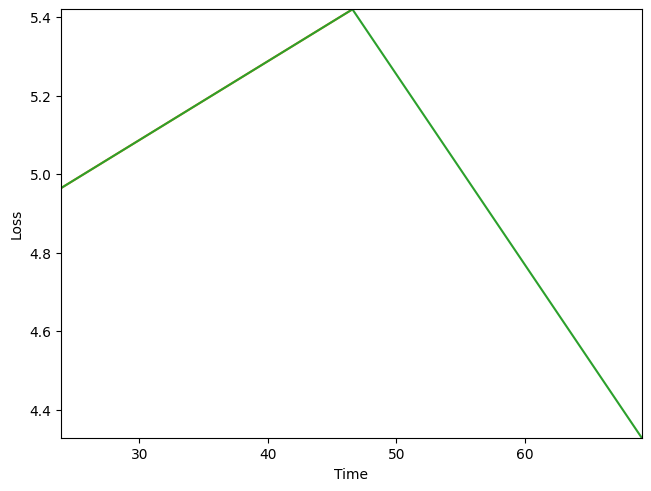

'elapsed: 0:01:09.087533 files_processed: 262 files_per_second: 3.7764752653608085'

''

'Last few loss averages: [4.964944198018029, 5.420202451944351, 4.328375133872032]'

'loss_1: 0.0762932151556015 loss_2: 3.3133180141448975 loss_3: 0.9709884524345398'

'torch.cuda.memory_reserved 10: 16.677734GB'

/home/jacob/jupyter-venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
/home/jacob/jupyter-venv/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


KeyboardInterrupt: 

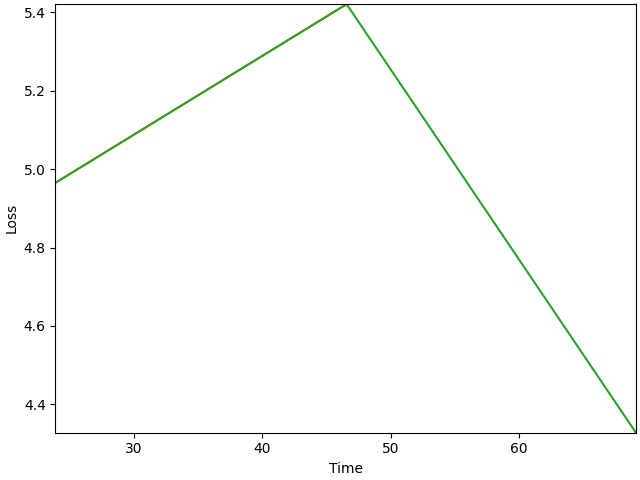

In [8]:
%%time

%matplotlib widget

### Train

files_processed = 0

t0 = time.time()

last_short_update_at = None

short_update = 20
long_update = 50
very_long_update = 1000

noisy_loader_iter = iter(noisy_loader)
clear_loader_iter = iter(clear_loader)
epoch_count = 0
files_processed_at_last_short_update = 0

# custom_batching_size = 3
samples_per_iteration = 24000 * 24

figdisplay = display.display("", display_id=True)
fig, axs = plt.subplots(1, 1, layout='constrained')
axs.set_xlabel('Time')
axs.set_ylabel('Loss')

# Add hover annotations
# cursor = mplcursors.cursor(axs, hover=True)
# cursor.connect("add", lambda sel: sel.annotation.set_text(f"Loss: {loss_numbers[sel.index]:.2f}\nTime: {loss_times[sel.index]:.2f}"))

loss_numbers = []
loss_numbers_short_update = []
loss_times = []

noisy_display = display.display("", display_id=True)
prediction_display = display.display("", display_id=True)
clear_display = display.display("", display_id=True)

status_string_display = display.display("", display_id=True)
last_save_status_string_display = display.display("", display_id=True)
last_few_loss_display = display.display("", display_id=True)
specific_loss_display = display.display("", display_id=True)
memory_max_display = display.display("", display_id=True)

with torch.cuda.device(0):
    # restart around the same place in the dataset after an OOM
    # for i in range(417000 // custom_batching_size):
    #     noisy_batch = [next(noisy_loader_iter)]
    #     clear_batch = [next(clear_loader_iter)]
    
    gc.collect()
    torch.cuda.empty_cache()
    
    remaining_noisy_samples = None
    remaining_clear_samples = None
    
    # print("torch.cuda.memory_reserved 1: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
    
    while(True):
        if remaining_noisy_samples is not None:
            noisy = remaining_noisy_samples
            clear = remaining_clear_samples
            remaining_noisy_samples = None
            remaining_clear_samples = None
        else:                    
            noisy = next(noisy_loader_iter)[0].squeeze(0).squeeze(0).to(device)
            clear = next(clear_loader_iter)[0].squeeze(0).squeeze(0).to(device)
            files_processed += 1
            
        # print("torch.cuda.memory_reserved 2: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
        
        while noisy.size()[0] < samples_per_iteration:
            # print(f"Grabbing more from dataset to fill to {samples_per_iteration}. Size: {noisy.size()[0]}")
            noisy = torch.cat((noisy, next(noisy_loader_iter)[0].squeeze(0).squeeze(0).to(device)), dim=0)
            clear = torch.cat((clear, next(clear_loader_iter)[0].squeeze(0).squeeze(0).to(device)), dim=0)
            files_processed += 1
            
        # print("torch.cuda.memory_reserved 3: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
        
        noisy_limited = noisy[:samples_per_iteration]
        clear_limited = clear[:samples_per_iteration]

        # print(f"noisy_limited 1: {noisy_limited}")
        
        if noisy.size()[0] > samples_per_iteration:
            remaining_noisy_samples = noisy[samples_per_iteration:]
            remaining_clear_samples = clear[samples_per_iteration:]
            # print(f"samples_per_iteration: {samples_per_iteration}: Saving {remaining_noisy_samples.size()[0]} for next round")

        del noisy, clear

        # print("torch.cuda.memory_reserved 4: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
                
        noisy_subsamples = torch.split(noisy_limited, samples_per_batch)
        clear_subsamples = torch.split(clear_limited, samples_per_batch)

        noisy_subsamples = torch.stack(noisy_subsamples).unsqueeze(1)
        clear_subsamples = torch.stack(clear_subsamples).unsqueeze(1)

        if not (epoch_count % long_update == 0):
            del noisy_limited, clear_limited
        
        loss_sum = 0
        
        # gc.collect()        
        # torch.cuda.empty_cache()

        # print("torch.cuda.memory_reserved 6: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
        
        sequence_model.train()
        
        prediction = sequence_model(noisy_subsamples)
        
        if epoch_count % long_update == 0:
            prediction_cpu = prediction.cpu()
        else:
            prediction_cpu = None

        loss_1 = loss_fn(prediction, clear_subsamples)
        loss_2 = loss_fn_2(prediction, clear_subsamples)
        loss_3 = (loss_fn_3(prediction, clear_subsamples) / 3)
        # loss_4 = loss_fn_4(prediction, clear_subsamples)
        
        loss = loss_1 + loss_2 + loss_3
        loss_numbers_short_update.append(loss.item())

        specific_loss_string = f"loss_1: {loss_1} loss_2: {loss_2} loss_3: {loss_3}"

        # print("torch.cuda.memory_reserved 7: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
        
        del prediction, noisy_subsamples, clear_subsamples
        # gc.collect()
        # torch.cuda.empty_cache()
        
        # print("torch.cuda.memory_reserved 8: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
        
        optimizer.zero_grad()
        
        loss.backward()
        
        # print("torch.cuda.memory_reserved 9: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
        
        del loss, loss_1, loss_2, loss_3
        # gc.collect()
        # torch.cuda.empty_cache()
        
        optimizer.step()
        scheduler.step()
        
        sequence_model.eval()
        
        # print("torch.cuda.memory_reserved 10: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
        
        # gc.collect()        
        # torch.cuda.empty_cache()

        if epoch_count % short_update == 0 and epoch_count != 0:
            now = time.time()
            elapsed_str = str(timedelta(seconds=now - t0))
            files_per_second = float(files_processed - files_processed_at_last_short_update) / (now - last_short_update_at if last_short_update_at else now - t0) 
            status_string_display.update(f"elapsed: {elapsed_str} files_processed: {files_processed} files_per_second: {files_per_second}")
            last_short_update_at = time.time()
            files_processed_at_last_short_update = files_processed
            
            elapsed_seconds = timedelta(seconds=now - t0).total_seconds()
            
            avg_loss = sum(loss_numbers_short_update) / len(loss_numbers_short_update)
            loss_numbers_short_update = []
            
            loss_times.append(elapsed_seconds)
            loss_numbers.append(avg_loss)
            
            # Plot loss data
            # todo: performant sliding window update lines?
            plt.plot(loss_times, loss_numbers)

            last_few_loss_avgs = loss_numbers[-10:]
            last_few_loss_display.update(f"Last few loss averages: {last_few_loss_avgs}")

            specific_loss_display.update(specific_loss_string)
            
            plt.autoscale(tight=True)

            figdisplay.update(fig)
            fig.canvas.draw()

            memory_max_display.update("torch.cuda.memory_reserved 10: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))

            if epoch_count > 2000:
                short_update = 200
            if epoch_count > 4000:
                short_update = 400

        if epoch_count % long_update == 0:
            if prediction_cpu is not None:
                noisy_display.update(display.Audio(noisy_limited.cpu().detach(), rate=sample_rate))
                prediction_reconstructed = prediction_cpu.view(25, -1).view(1, -1)
                prediction_display.update(display.Audio(prediction_reconstructed.cpu().detach(), rate=sample_rate))
                clear_display.update(display.Audio(clear_limited.cpu().detach(), rate=sample_rate))
            else:
                print(f"prediction_cpu is None!")

        if epoch_count % very_long_update == 0 and epoch_count != 0:
            model_save_path = models_dir + f"/model-{time.strftime("%Y%m%d-%H%M%S")}"
            last_save_status_string_display.update(f"Saving model to {model_save_path}")
            torch.save(sequence_model.state_dict(), model_save_path)

        epoch_count += 1

    print("Finished!")

        # print("torch.cuda.memory_reserved 11: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
        
        # gc.collect()
        # torch.cuda.empty_cache()
        
        # print(f"**** Training iteration complete ****")
        
        # print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
        # print("torch.cuda.memory_reserved: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
        # print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(0)/1024/1024/1024))


        
        
